In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cf
from netCDF4 import Dataset
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import matplotlib.pyplot as plt
from xarray.backends import NetCDF4DataStore
import xarray as xr
import pynmet
import pandas as pd

In [2]:
cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/nws/synoptic/ncdecoded/catalog.xml')
best_ds = list(cat.datasets.values())[0]
ncss = best_ds.subset()

query = ncss.query()

In [7]:
time = datetime.utcnow()-timedelta(hours=6)
delta = timedelta(hours=6)
query.lonlat_box(north=-25, south=-40, east=330, west=300).time(time).accept('netcdf4')
query.variables( 'all')
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

In [8]:
data.data_vars

Data variables:
    VIS            (obs) float64 ...
    SPD            (obs) float32 ...
    char_Ptend     (obs) float64 ...
    stnName        (obs) |S6 ...
    WXpresent      (obs) float64 ...
    Tb             (obs) float32 ...
    snowDepth      (obs) float64 ...
    cloudObsured   (obs, cloud_levels) float64 ...
    stnType        (obs) float64 ...
    PRECIP_period  (obs) timedelta64[ns] ...
    Hwa            (obs) float64 ...
    wmoId          (obs) float64 ...
    T              (obs) float32 ...
    PRES           (obs) float32 ...
    SLP            (obs) float32 ...
    humidity       (obs) float64 ...
    Tmin           (obs) float32 ...
    PRECIP_amt24   (obs) float32 ...
    Pwa            (obs) timedelta64[ns] ...
    meanWind       (obs) float64 ...
    cloudLow       (obs) float64 ...
    Hwa_tenths     (obs) float32 ...
    cloudHigh      (obs) float64 ...
    Tw             (obs) float32 ...
    cloudGenus     (obs, cloud_levels) float64 ...
    PRECIP_amt     

In [9]:
temp = data.data_vars['T']
pres = data.data_vars['PRES']
precip = data.data_vars['PRECIP_amt24']
lat = pres.latitude.values
lon = pres.longitude.values
time2 = pres.time.values

In [12]:
from tqdm import tqdm
tempo=[]
for t in tqdm(set(time2)):
    c=0
    features=[]
    for x,y in zip(lon,lat):
        p_time = t
        p_lon = x
        p_lat = y
        p = pres.values[c]
        tmp = temp.values[c]
        chu = precip.values[c]
        x_ = p_lon, p_lat, p, tmp, chu
        features.append(x_)
        c+=1
    tempo.append(features) 

100%|██████████| 1/1 [00:00<00:00, 374.83it/s]


In [13]:
tempo = np.array(tempo)
tempo.shape

(1, 57, 5)

In [11]:
from metpy.interpolate import interpolate_to_grid
x_t,y_t,z_temp = interpolate_to_grid(lon,lat,temp.values,interp_type='cressman',hres=0.05, minimum_neighbors=1)
x_p,y_p,z_press = interpolate_to_grid(lon,lat,pres.values,interp_type='cressman',hres=0.05, minimum_neighbors=1)

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


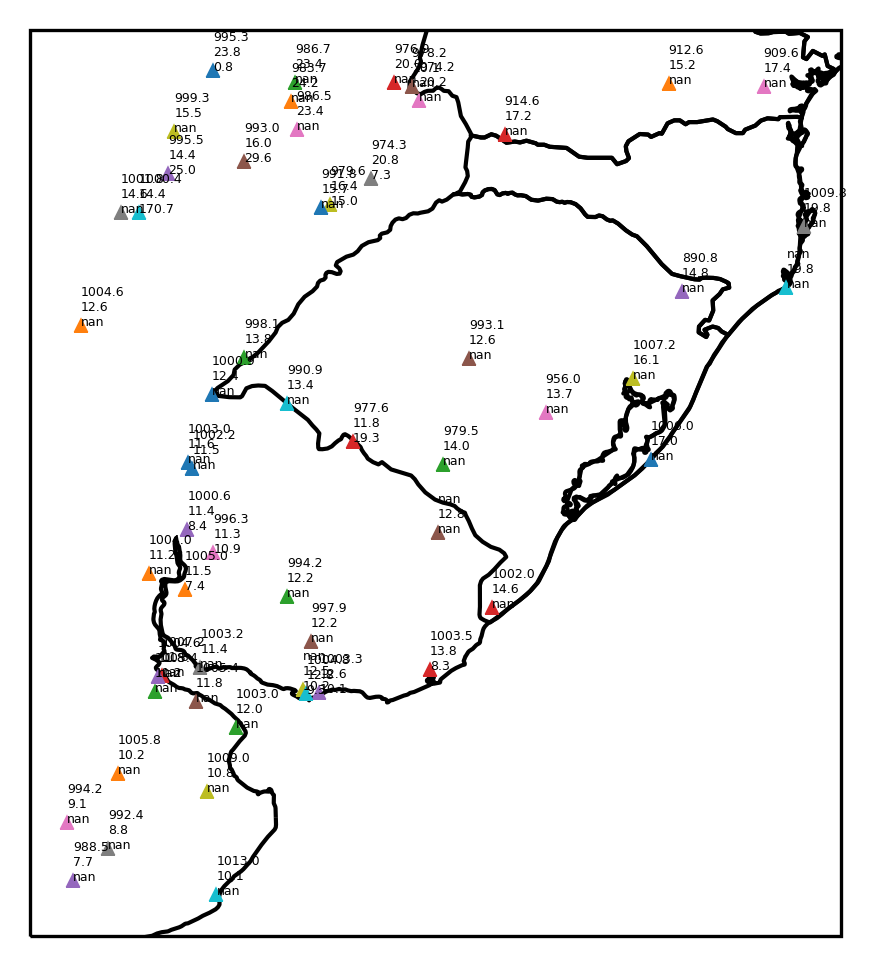

In [18]:
resolucao='50m'
cor = 'black'
largura_linha = 1
fig = plt.figure(dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax2 = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
states = cf.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp',  linewidth=largura_linha)
ax.add_feature(states, edgecolor='black')
c=0
for i,j, in zip(lon,lat):
    plt.plot(i,j,'^',markersize=2)
    plt.text(i,j,
str(round(float(pres[c].values),1))+'\n'+str(round(float(temp[c].values),1))+'\n'+str(round(float(precip[c].values),1)),fontsize=3)
    c+=1


plt.show()

In [16]:
x, y, z = np.meshgrid(x_t, y_t, z_temp)

MemoryError: Unable to allocate 1.36 PiB for an array with shape (57658, 57658, 57658) and data type float64

In [17]:
x_t.shape, y_t.shape, z_temp.shape

((254, 227), (254, 227), (254, 227))

In [62]:
len(lat)

47

In [18]:
z_temp

array([[ 8.977509 ,  8.99869  ,  9.019291 , ...,        nan,        nan,
               nan],
       [ 9.008069 ,  9.028769 ,  9.048916 , ...,        nan,        nan,
               nan],
       [ 9.037831 ,  9.058078 ,  9.0778   , ...,        nan,        nan,
               nan],
       ...,
       [18.755817 , 18.777723 , 18.799078 , ..., 13.97922  , 13.996211 ,
        14.013659 ],
       [18.792675 , 18.81415  , 18.835094 , ..., 13.989228 , 14.006272 ,
        14.0237875],
       [18.830248 , 18.851267 , 18.871777 , ..., 13.99953  , 14.016641 ,
        14.034238 ]], dtype=float32)